In [1]:
from alntk.alignment import import_from_fasta, get_unaligned_seqs, get_compact_alignment, write_to_fasta
from alntk.plotting import default_plot_style

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
color_cycle = default_plot_style()
data_folder = '../data/'

# Iterative approach to compactifying the alignment

In summary, the first approach I'm attempting to get a smaller alignment is to make it "compact". This is done by the elimination of sequences, and by deleting some sequences I'm hoping to get columns that are entirely gaps. If I delete the right sequences, I should be able to delete the entirely gapped columns and get a more compact alignment. However, this does not guarantee me that I will necessarily get less gaps: in fact, as soon as I delete the columns, the distribution might change. Let's see what happens.

In [4]:
new_aln_descs, new_aln_seqs = import_from_fasta(data_folder + 'new_aln.faa')
np.random.seed(42)
subsample_mask = np.random.randint(0, len(new_aln_descs), size=10_000)
subaln_seqs = new_aln_seqs[subsample_mask]
subaln_descs = new_aln_descs[subsample_mask]

In [5]:
subaln_seqs.shape

(10000, 693)

# Number of sequences/columns per iteration

Let's plot the dimension of the alignments per thresholds (say 0.8, 0.9, 0.99 and 0.999) by doing 20 iterations.

In [6]:
thresholds = [0.8, 0.9, 0.99, 0.999]
c_aln_shapes_thr = []
for threshold in thresholds:
    c_aln_shapes = []
    sad0, sas0 = subaln_descs, subaln_seqs
    for i in range(20):
        c_aln_shapes.append(sas0.shape)
        sadf, sasf = get_compact_alignment(sad0, sas0, threshold, tol_uaa=.02)
        sad0, sas0 = sadf, sasf
    c_aln_shapes.append(sas0.shape)
    c_aln_shapes = np.array(c_aln_shapes)
    c_aln_shapes_thr.append(c_aln_shapes)
c_aln_shapes_thr = np.array(c_aln_shapes_thr)

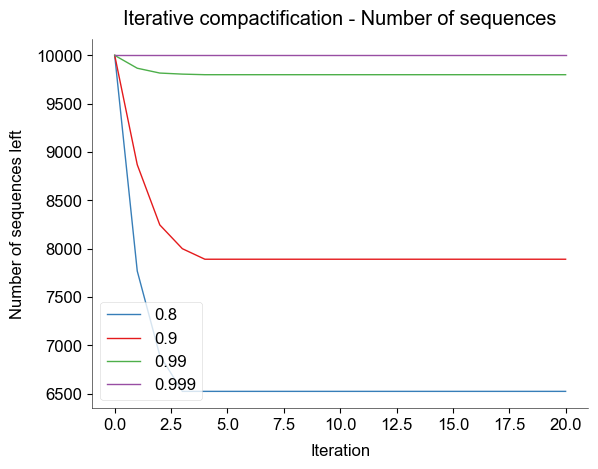

In [7]:
fig, ax = plt.subplots()
plt.title('Iterative compactification - Number of sequences')
for thr_idx, threshold in enumerate(thresholds):
    ax.plot(c_aln_shapes_thr[thr_idx, :, 0], color='#'+color_cycle[thr_idx], label=str(threshold))
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Number of sequences left')
plt.show()

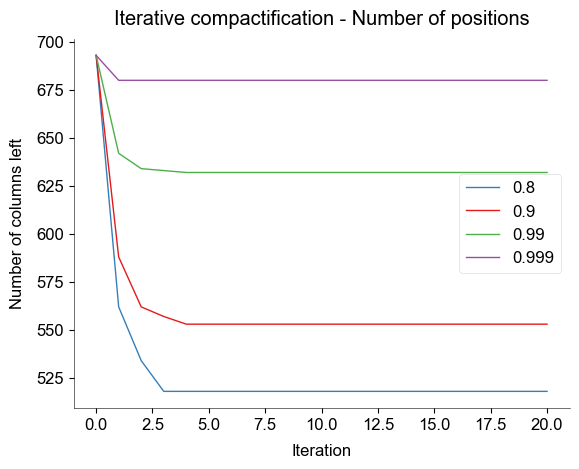

In [8]:
fig, ax = plt.subplots()
plt.title('Iterative compactification - Number of positions')
for thr_idx, threshold in enumerate(thresholds):
    ax.plot(c_aln_shapes_thr[thr_idx, :, 1], color='#'+color_cycle[thr_idx], label=str(threshold))
plt.xlabel('Iteration')
plt.ylabel('Number of columns left')
plt.legend()
plt.show()

# Distribution of gaps in columns per iteration for different thresholds

We can plot the distribution of the ratio of gaps per column as a histogram. Our goal is to see whether, as we iterate through the compactification steps, we get a convergence to a distribution of values and whether it has a peak at highly gapped columns.

We see that we get reasonably low amount of gapped columns for thresholds 0.9 and 0.95, while at 0.99 the iterations converge to a distribution with a peak on highly gapped columns.

{'G5AE35', 'Q90WD8', 'P86091', 'Q7M4I3', 'Q9GZN4', 'Q05589', 'A0A126GUP6', 'Q95ND7', 'P00738', 'Q5K4E3', 'Q8SQ23', 'B1AC87', 'P15946', 'Q9VCJ8', 'B7YZU2', 'Q07276', 'J3RYA3', 'Q5G268', 'Q9ES87', 'B5U2W0', 'Q8MHY7', 'O35205', 'Q8I6K0', 'P33619', 'Q8BJR6', 'P35047', 'P23605', 'P27435'}
{'Q7SIG3', 'Q86T26', 'P05208', 'E0Y420', 'P82981', 'P35587', 'P08419', 'Q7SZE2', 'Q8JH85', 'Q9BYE2', 'P35044', 'I4CHP3', 'Q9I8X2'}
{'P50339', 'P0DJF5', 'Q91516', 'P08311', 'P0CJ41', 'P08897', 'P50341', 'Q06605', 'Q71QJ2', 'P51124'}
['P32038', 'P49862', 'Q6ZMR5', 'Q3T0A3', 'P08426', 'Q7Z410', 'P12788', 'P03951', 'P00760']


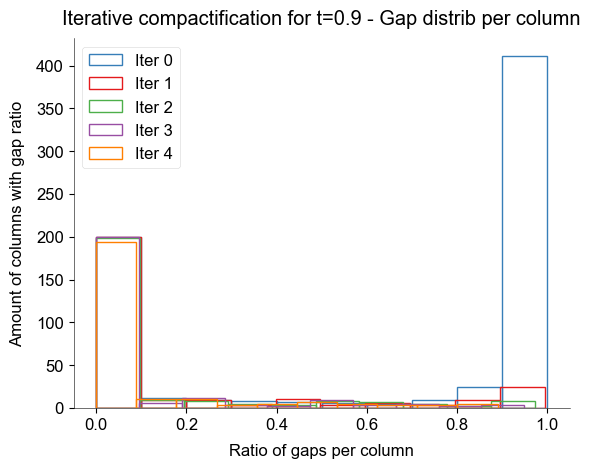

In [9]:
threshold = 0.9
c_aln_shapes = []
sad0, sas0 = subaln_descs, subaln_seqs
plt.title(f'Iterative compactification for t={threshold} - Gap distrib per column')
for i in range(4):
    c_aln_shapes.append(sas0.shape)
    current_sp = set([d.split('|')[1] for d in sadf if d.split('|')[0]=='sp'])
    if i>0: print(prev_sp - current_sp)
    plt.hist(np.sum(sas0 == '-', axis=0) / sas0.shape[0], label='Iter '+str(i), facecolor='none', edgecolor='#'+color_cycle[i], linewidth=1)
    sadf, sasf = get_compact_alignment(sad0, sas0, threshold)
    sad0, sas0 = sadf, sasf
    prev_sp = current_sp
print([d.split('|')[1] for d in sadf if d.split('|')[0]=='sp'])
plt.hist(np.sum(sas0 == '-', axis=0) / sas0.shape[0], label='Iter '+str(i+1), facecolor='none', edgecolor='#'+color_cycle[i+1], linewidth=1)
c_aln_shapes.append(sas0.shape)
c_aln_shapes = np.array(c_aln_shapes)
plt.xlabel('Ratio of gaps per column')
plt.ylabel('Amount of columns with gap ratio')
plt.legend()
plt.show()

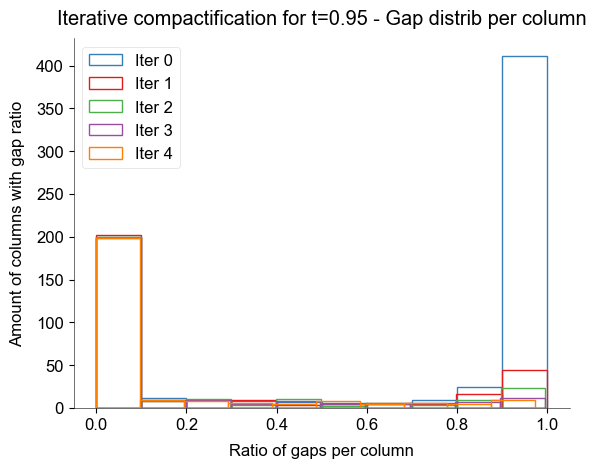

In [10]:
threshold = 0.95
c_aln_shapes = []
sad0, sas0 = subaln_descs, subaln_seqs
plt.title(f'Iterative compactification for t={threshold} - Gap distrib per column')
for i in range(4):
    c_aln_shapes.append(sas0.shape)
    # current_sp = set([d.split('|')[1] for d in sadf if d.split('|')[0]=='sp'])
    # if i>0: print(prev_sp - current_sp)
    plt.hist(np.sum(sas0 == '-', axis=0) / sas0.shape[0], label='Iter '+str(i), facecolor='none', edgecolor='#'+color_cycle[i], linewidth=1)
    sadf, sasf = get_compact_alignment(sad0, sas0, threshold)
    sad0, sas0 = sadf, sasf
#     prev_sp = current_sp
# print([d.split('|')[1] for d in sadf if d.split('|')[0]=='sp'])
plt.hist(np.sum(sas0 == '-', axis=0) / sas0.shape[0], label='Iter '+str(i+1), facecolor='none', edgecolor='#'+color_cycle[i+1], linewidth=1)
c_aln_shapes.append(sas0.shape)
c_aln_shapes = np.array(c_aln_shapes)
plt.xlabel('Ratio of gaps per column')
plt.ylabel('Amount of columns with gap ratio')
plt.legend()
plt.show()

In [11]:
iter_positions = np.arange(0, 693)
sad0, sas0 = subaln_descs, subaln_seqs
for i in range(4):
    sadf, sasf, gp = get_compact_alignment(sad0, sas0, threshold, return_gappy_pos=True)
    sad0, sas0 = sadf, sasf
    iter_positions = np.delete(iter_positions, gp)

In [20]:
print('[' + ','.join(map(str, list(iter_positions))) + ']')

[0,1,2,3,35,36,37,38,39,40,82,83,84,85,86,87,88,89,90,91,92,93,94,110,111,112,113,114,115,116,117,118,119,120,121,122,129,130,131,132,133,134,147,148,149,150,151,152,153,154,155,156,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,280,281,282,283,307,308,309,310,311,312,313,333,334,335,336,337,338,352,353,354,355,356,357,358,359,360,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,399,400,401,402,421,422,423,424,425,430,431,433,434,435,436,437,438,439,440,441,469,470,471,472,473,474,475,476,477,478,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,520,521,522,523,524,525,526,527,528,530,531,532,533,534,535,536,537,538,544,545,546,547,548,549,550,551,552,553,554,555,556,557,563,564,565,566,567,568,569,575,576,577,578,579,580,581,582,583,584,591,592,593,594,595,596,597,598,599,600,60

In [23]:
print('['+','.join(map(str, set(np.arange(0,693)) - set(iter_positions)))+']')

[4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,123,124,125,126,127,128,135,136,137,138,139,140,141,142,143,144,145,146,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,279,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,339,340,341,342,343,344,345,346,347,348,349,350,351,361,362,363,364,365,366,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,426,427,428,42

In [20]:
write_to_fasta(new_aln_descs, new_aln_seqs[:, iter_positions], data_folder+'iter_aln.faa')

In [22]:
write_to_fasta(new_aln_descs, new_aln_seqs[subsample_mask][:, iter_positions], data_folder+'iter_aln_subsample.faa')

In [23]:
len(iter_positions)

262

set()
{'P51588', 'A0A182C2Z2', 'P85202', 'Q9BZJ3', 'Q61754'}
{'Q966V2', 'Q7M4I3', 'Q9UKQ9'}
['Q5G267', 'Q91509', 'Q9UNI1', 'Q6UWY2', 'Q90629', 'Q26422', 'P80420', 'Q8VHJ4', 'Q66TN7', 'P11034', 'P16296', 'P70375', 'Q9BYE2', 'P08897', 'Q5G269', 'Q71QJ2', 'U5YCR8', 'Q8AY80', 'O13069', 'A8QL56', 'P42278', 'O13062', 'P00772', 'P35042', 'P32821', 'Q91041', 'Q9PT41', 'P19799', 'P81176', 'Q9ER04', 'P25155', 'Q71QI5', 'Q5G271', 'P08882', 'P18965', 'P35032', 'Q27083', 'P20231', 'Q09GK1']


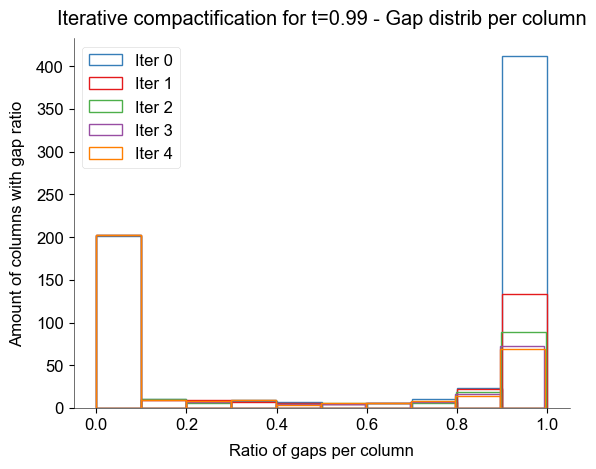

In [11]:
threshold = 0.99
c_aln_shapes = []
sad0, sas0 = subaln_descs, subaln_seqs
plt.title(f'Iterative compactification for t={threshold} - Gap distrib per column')
for i in range(4):
    c_aln_shapes.append(sas0.shape)
    current_sp = set([d.split('|')[1] for d in sadf if d.split('|')[0]=='sp'])
    if i>0: print(prev_sp - current_sp)
    plt.hist(np.sum(sas0 == '-', axis=0) / sas0.shape[0], label='Iter '+str(i), facecolor='none', edgecolor='#'+color_cycle[i], linewidth=1)
    sadf, sasf = get_compact_alignment(sad0, sas0, threshold)
    sad0, sas0 = sadf, sasf
    prev_sp = current_sp
print([d.split('|')[1] for d in sadf if d.split('|')[0]=='sp'])
plt.hist(np.sum(sas0 == '-', axis=0) / sas0.shape[0], label='Iter '+str(i+1), facecolor='none', edgecolor='#'+color_cycle[i+1], linewidth=1)
c_aln_shapes.append(sas0.shape)
c_aln_shapes = np.array(c_aln_shapes)
plt.xlabel('Ratio of gaps per column')
plt.ylabel('Amount of columns with gap ratio')
plt.legend()
plt.show()

# Test SP on entire alignment

0.95 seems to be a reasonable choice for the threshold of compactification. Let's see at five iterations of compactification which are the SwissProt sequences that we are throwing away. We are interested in skimming through the compactified sequences on the entire 

The last line is the remaining SwissProt entries. We can see that `CELA1_PIG`, `CTRA_BOVIN` and `TRY2_RAT` are still in the last alignment.

```
P80219, P00772, P00763, P00766, P00734
```

In [6]:
known_upkbid = ['TRY2_RAT', 'THRB_HUMAN', 'CELA1_PIG', 'DDN1_BOVIN', 'CTRA_BOVIN']
for i, d in enumerate(new_aln_descs):
    n = d.split('|')[2]
    if n in known_upkbid:
        print(i, n, np.sum(new_aln_seqs[i]!='-'))

7105 TRY2_RAT 223
14901 DDN1_BOVIN 230
16943 CTRA_BOVIN 230
18287 CELA1_PIG 240
46064 THRB_HUMAN 257


In [7]:
new_aln_seqs.shape

(103940, 693)


gappypos
 [  4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21
  22  23  24  25  26  27  28  29  30  31  32  33  34  41  42  43  44  45
  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
  96  97  98  99 100 101 102 103 104 105 106 107 123 124 125 126 127 128
 135 136 137 138 139 140 141 142 143 144 145 146 159 160 161 162 163 164
 165 166 167 168 169 170 171 172 173 174 175 176 197 198 199 200 201 202
 203 204 205 206 207 208 209 210 211 212 213 214 215 241 242 243 244 245
 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 279 286
 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304
 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332
 339 340 341 342 343 344 345 346 347 348 349 350 351 361 362 363 364 365
 366 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 403 404
 405 406 407 408 409 410 411 412 413 414

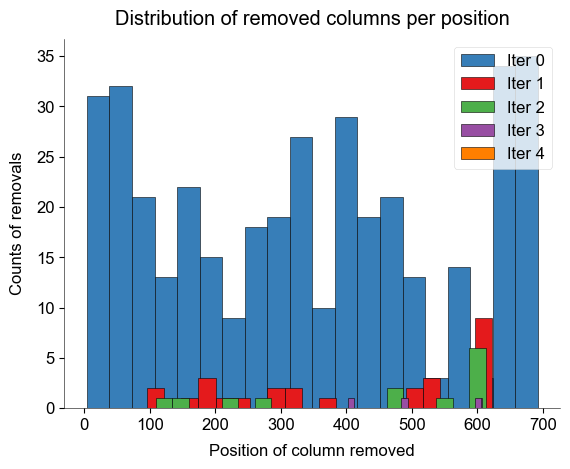

In [8]:
threshold = 0.95
sad0, sas0 = new_aln_descs, new_aln_seqs
gps = []
rps = []
kept_seq_pos = np.arange(0, new_aln_seqs.shape[1])
fig = plt.figure()
plt.title('Distribution of removed columns per position')
for i in range(5):
    current_sp = set([d.split('|')[1] for d in sad0 if d.split('|')[0]=='sp'])
    if i>0:
        diff_sp = prev_sp - current_sp
        print(','.join(diff_sp))
    sadf, sasf, gp = get_compact_alignment(sad0, sas0, threshold, return_gappy_pos=True)
    print('\ngappypos\n', gp)
    removed_seq_pos = kept_seq_pos[gp]
    rps.append(removed_seq_pos)
    kept_seq_pos = np.delete(kept_seq_pos, gp)
    plt.hist(removed_seq_pos, label=f'Iter {i}', bins=20)
    sad0, sas0 = sadf, sasf
    prev_sp = current_sp
    gps.append(gp)
    print('Iteration', i)
print(','.join([d.split('|')[1] for d in sadf if d.split('|')[0]=='sp']))
plt.legend()
plt.xlabel('Position of column removed')
plt.ylabel('Counts of removals')
plt.show()

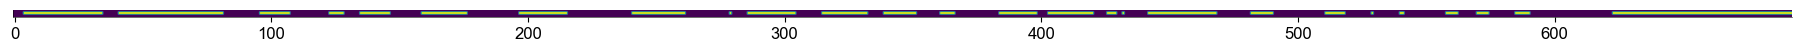

In [34]:
plt.figure(figsize=(30,.1))
plt.imshow([[False for i in range(693)], [True if (e in set(rps[0])) else False for e in range(693)], [False for i in range(693)]])
plt.yticks([])
plt.show()

Why the Thrombin was deleted?

In [28]:
new_aln_seqs[46064, rps[0]]

array(['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-',
       '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-',
       '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-',
       '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-',
       '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-',
       '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-',
       '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-',
       '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', 'N', '-',
       '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-',
       '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-',
       '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-',
       '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-',
       '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-',
       '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-

What are the final positions in terms of the indices of the original alignment?

In [18]:
# kept_seq_pos = np.arange(0, new_aln_seqs.shape[1])
# for gp in gps:
#     kept_seq_pos = np.delete(kept_seq_pos, gp)
print('['+','.join(map(str, list(kept_seq_pos)))+']')

[0,1,2,3,35,36,37,38,39,40,82,83,84,85,86,87,88,89,90,91,92,93,94,110,111,112,113,114,115,116,117,118,119,120,121,122,129,130,131,132,133,134,147,148,149,150,151,152,153,154,155,156,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,280,281,282,283,307,308,309,310,311,312,313,333,334,335,336,337,338,352,353,354,355,356,357,358,359,360,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,399,400,401,421,422,423,424,425,430,431,433,434,435,436,437,438,439,440,441,469,470,471,472,473,474,475,476,477,478,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,520,521,522,523,524,525,526,527,528,530,531,532,533,534,535,536,537,538,544,545,546,547,548,549,550,551,552,553,554,555,556,557,563,564,565,566,567,568,569,575,576,577,578,579,580,581,582,583,584,591,592,593,594,595,596,597,598,599,600,601,60

In [16]:
sasf.shape

(20593, 260)

In [30]:
write_to_fasta(sadf, sasf, data_folder + 'iter.faa')

In [72]:
import json
import re

In [89]:
with open(data_folder+'idmapping_2024_10_17.json', 'r') as f:
    idm_aln = json.load(f)
    for result in idm_aln['results']:
        print(result['to']['uniProtkbId'])
        for comment in result['to']['comments']:
            if comment['commentType'] == 'CATALYTIC ACTIVITY':
                cat_act = comment['reaction']['name']
                try:
                    cat_list = re.split(', | and | >> | > ', cat_act.split('Preferential cleavage: ')[1].split('.')[0])
                    print(cat_list)
                except:
                    print('no info')

TMPS9_HUMAN
TMPS9_MOUSE
TRY4_MOUSE
['Arg-|-Xaa', 'Lys-|-Xaa']
TRY1_RAT
['Arg-|-Xaa', 'Lys-|-Xaa']
TRY2_CANLF
['Arg-|-Xaa', 'Lys-|-Xaa']
TRY2_RAT
['Arg-|-Xaa', 'Lys-|-Xaa']
TRY1_HUMAN
['Arg-|-Xaa', 'Lys-|-Xaa']
TRY2_MOUSE
['Arg-|-Xaa', 'Lys-|-Xaa']
TRY5_MOUSE
['Arg-|-Xaa', 'Lys-|-Xaa']
TRY6_HUMAN
['Arg-|-Xaa', 'Lys-|-Xaa']
TRY2_HUMAN
['Arg-|-Xaa', 'Lys-|-Xaa']
TRY3_RAT
['Arg-|-Xaa', 'Lys-|-Xaa']
TRY3_CHICK
['Arg-|-Xaa', 'Lys-|-Xaa']
TRY3_HUMAN
['Arg-|-Xaa', 'Lys-|-Xaa']
TRYP_PIG
['Arg-|-Xaa', 'Lys-|-Xaa']
TRY1_BOVIN
['Arg-|-Xaa', 'Lys-|-Xaa']
TRY2_BOVIN
['Arg-|-Xaa', 'Lys-|-Xaa']
TRY2_XENLA
['Arg-|-Xaa', 'Lys-|-Xaa']
TRY1_XENLA
['Arg-|-Xaa', 'Lys-|-Xaa']
TRY1_SALSA
['Arg-|-Xaa', 'Lys-|-Xaa']
TRY1_CANLF
['Arg-|-Xaa', 'Lys-|-Xaa']
TRY1_CHICK
['Arg-|-Xaa', 'Lys-|-Xaa']
TRY2_CHICK
['Arg-|-Xaa', 'Lys-|-Xaa']
TRYA_RAT
['Arg-|-Xaa', 'Lys-|-Xaa']
TRY4_RAT
['Arg-|-Xaa', 'Lys-|-Xaa']
TRYB_RAT
['Arg-|-Xaa', 'Lys-|-Xaa']
TRYX_GADMO
['Arg-|-Xaa', 'Lys-|-Xaa']
CEL2A_PIG
['Leu-|-Xaa', 'Met-|-Xaa', 'Ph